In [1]:
import numpy as np
from scipy import integrate    
import matplotlib.pyplot as plt
import itertools
import arviz as az
import seaborn as sns
import pandas as pd
import pickle
sns.set_style("darkgrid")
pd.set_option('display.precision',1)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:.2g}'.format)

from rsindy.rsindy_bayes import *

### Model
$$
\begin{align*}
    \phi &\overset{\theta_1}{\to} R \\
    R &\overset{\theta_2}{\to} \phi \\
    L + R &\overset{\theta_3}{\to} RL + L \\
    RL &\overset{\theta_4}{\to} R \\
    RL + G &\overset{\theta_5}{\to} G_a + G_{bg} \\
    G_a &\overset{\theta_6}{\to} G_d \\
    G_d + G_{bg} &\overset{\theta_7}{\to} G \\
    RL &\overset{\theta_8}{\to} \phi
\end{align*}
$$

which can be translated into

$$
\begin{align*}
    \frac{dR}{dt} &= \theta_1 + \theta_4 RL - \theta_2 R - \theta_3(R)L \\
    \frac{dL}{dt} &= 0 \\
    \frac{dRL}{dt} &= \theta_3 (R)L - \theta_4 R - \theta_8 RL \\
    \frac{dG}{dt} &= \theta_7(G_d)G_{bg} - \theta_5(RL)G \\
    \frac{dG_a}{dt} &= \theta_5 (RL)G - \theta_6 (G_d)G_{bg} \\
    \frac{dG_{bg}}{dt} &= \theta_5 (RL)G - \theta_7 (G_d)G_{bg} \\
    \frac{dG_d}{dt} &= \theta_6 G_a - \theta_7 (G_d)G_{bg}
\end{align*}
$$

In [7]:
def simulate_data(theta, t):
    
    X0 = [500, 4, 110, 300, 2, 20, 90]
    def dYdt(X, t = 0):
        R, L, RL, G, Ga, Gbg, Gd = X

        dRdt = theta[0] + theta[3] * RL - theta[1] * R - theta[2] * R * L
        dLdt = 0
        dRLdt = theta[2] * R * L - theta[3] * RL - theta[7] * RL - theta[4] * RL * G
        dGdt = theta[6] * Gd * Gbg - theta[4] * RL * G
        dGadt = theta[4] * RL * G - theta[5] * Ga
        dGbgdt = theta[4] * RL * G - theta[6] * Gd * Gbg
        dGddt = theta[5] * Ga - theta[6] * Gd * Gbg

        return [dRdt, dLdt, dRLdt, dGdt, dGadt, dGbgdt, dGddt]
    X_obs = integrate.odeint(dYdt, X0, t)
    X_obs_noisy = X_obs.copy()
    X_obs_noisy[1:,:] = np.exp(np.log(X_obs[1:,:]) + np.random.normal(0, 0.03, size = X_obs_noisy[1:,:].shape))

    return X_obs, X_obs_noisy

In [8]:
Strue = [[ 1, 0, 0, 0, 0, 0, 0, 0],
     [-1, 0, 0, 0, 0, 0, 0, 0],
     [-1, 0, 1, 0, 0, 0, 0, 0],
     [ 1, 0,-1, 0, 0, 0, 0, 0],
     [ 0, 0,-1,-1, 1, 1, 0, 0],
     [ 0, 0, 0, 0,-1, 0, 1, 0],
     [ 0, 0, 0, 1, 0,-1,-1, 0],
     [ 0, 0,-1, 0, 0, 0, 0, 0]]
Strue = np.array(Strue)
Rtrue = [[ 0, 0, 0, 0, 0, 0, 0, 1],
     [ 1, 0, 0, 0, 0, 0, 0, 0],
     [ 1, 1, 0, 0, 0, 0, 0, 0],
     [ 0, 0, 1, 0, 0, 0, 0, 0],
     [ 0, 0, 1, 1, 0, 0, 0, 0],
     [ 0, 0, 0, 0, 1, 0, 0, 0],
     [ 0, 0, 0, 0, 0, 1, 1, 0],
     [ 0, 0, 1, 0, 0, 0, 0, 0]]
Rtrue = np.array(Rtrue)
theta = [0.38, 0.04, 0.82, 0.12, 0.021, 0.1, 0.005, 0.21]
species_names = ['R', 'L', 'RL', 'G', 'Ga', 'Gbg', 'Gd']

### Observations

In [9]:
t = np.arange(0, 2, 0.1)
Z_obs, Z_obs_noisy = simulate_data(theta, t)

In [28]:
obs = {"t" : t,
       "Z_obs" : Z_obs,
       "Z_obs_noisy" : Z_obs_noisy}
pickle.dump(obs, open("results/gprotein/obs_0.03.p", "wb"))

### Plotting Observations

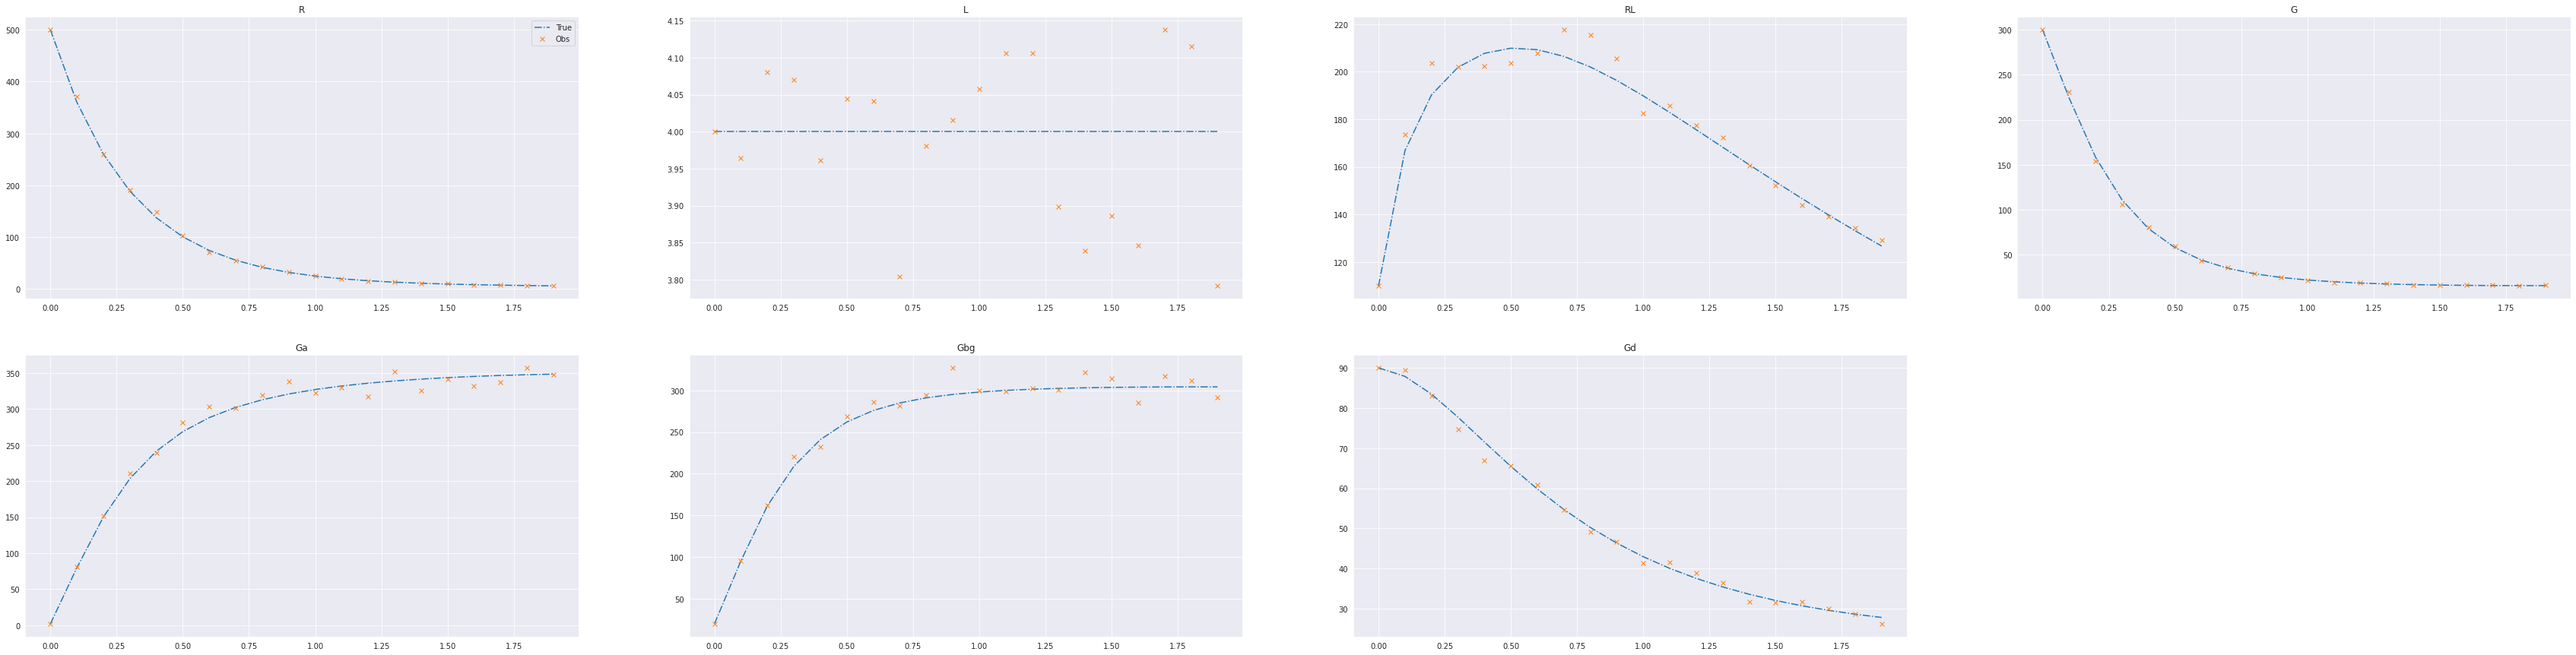

In [11]:
fig, ax = plt.subplots(2, 4)
for i in range(2):
    for j in range(4):
        if i * 4 + j < 7:
            ax[i,j].plot(t, Z_obs[:, i * 4 + j], '-.', label = 'True')
            ax[i,j].plot(t, Z_obs_noisy[:, i * 4 + j], 'x', label = 'Obs')
            ax[i,j].set_title(species_names[i * 4 + j])
            if i * 4 + j == 0:
                ax[i,j].legend()
        else:
            ax[i,j].axis('off')
fig.set_size_inches(60, 15)

## Non-Regularized Linear Regression

In [ ]:
bs_nonregularized = RSINDyNonRegularized(species_names)

In [ ]:
fit, reordered, S,R, D  = bs_nonregularized.fit_dx(
                                                Z_obs,
                                                 t,
                                                 known_S = Strue,
                                                 known_R = Rtrue,
                                                 known_rates = [],
                                                 N = bs_nonregularized.stoichiometry.shape[0] - Strue.shape[0],
                                                 model_params = {
                                                    'noise_sigma' : 1
                                                 },
                                                 fit_params = {
                                                    'chains' : 1,
                                                    'show_progress' : 'notebook',
                                                     'variational' : False
                                                 },
                                                 seed = 30
                                               )

In [ ]:
df = fit.summary(sig_figs=5)

In [ ]:
df[df.index.str.contains('^rate')]

## Regularized Horseshoe Bayesian Linear Regression

In [ ]:
bs_horseshoe = BSBRegularizedHorseshoe(species_names)

In [ ]:
fit_horseshoe_dx, _, S_dx, R_dx, D_dx = bs_horseshoe.fit_dx(
                                                     Z_obs,
                                                     t,
                                                     known_S = Strue,
                                                     known_R = Rtrue,
                                                     known_rates = [],
                                                     N = bs_horseshoe.stoichiometry.shape[0] - Strue.shape[0],
                                                     model_params = {
                                                        'm0' : 8,
                                                        'slab_scale' : 1,
                                                        'slab_df' : 4,
                                                        'sigma' : 0.001,
                                                        'noise_sigma' : 1
                                                     },
                                                     fit_params = {
                                                        'chains' : 1,
                                                        'show_progress' : 'notebook',
                                                         'variational' : False
                                                     },
                                                     seed = 30
                                                    )

In [ ]:
df = fit_horseshoe_dx.summary(sig_figs=5)

In [ ]:
df[df.index.str.contains('^rate')]

## No-DX

In [12]:
bs_horseshoe = RSINDyRegularizedHorseshoe(species_names)

In [13]:
fit_horseshoe_ndx, _, S_ndx, R_ndx, D_ndx = bs_horseshoe.fit_non_dx(
                                    Z_obs_noisy, 
                                    t,
                                    known_S = Strue,
                                    known_R = Rtrue,
                                    known_rates = theta[:5],
                                    N = bs_horseshoe.stoichiometry.shape[0] - Strue.shape[0],
                                    model_params = {
                                       'm0' : 3,
                                       'slab_scale' : 1,
                                       'slab_df' : 2,
                                       'sigma' : 0.0001,
                                       'noise_sigma' : 0.03
                                    },
                                    fit_params = {
                                       'chains' : 4,
                                        'iter_warmup' : 1000,
                                        'iter_sampling' : 300,
                                       'show_progress' : 'notebook',
                                        'max_treedepth' : 7,
                                        'variational' : False
                                    },
                                    seed = 30)                 

INFO:cmdstanpy:compiling stan program, exe file: /home/rmjiang/Other/bio_sindy/models/tempfile
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/rmjiang/Other/bio_sindy/models/tempfile


Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
fit_horseshoe_ndx.save_csvfiles("results/gprotein")
full_fit = {"fit": fit_horseshoe_ndx, 
        "S" : S_ndx, 
        "R" : R_ndx, 
        "D" : D_ndx
       }
pickle.dump(full_fit, open("results/gprotein/horseshoe_ndx_{:.2f}.p".format(0.03), "wb"))

In [ ]:
df = fit_horseshoe_ndx.summary(sig_figs=5)

In [ ]:
df[df.index.str.contains('^rate')]

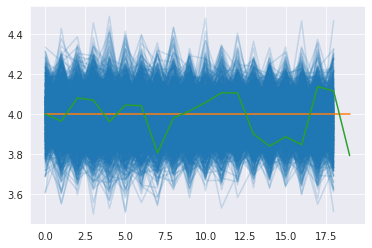

In [14]:
fig, ax = plt.subplots()
for i in range(1200):
    ax.plot(fit_horseshoe_ndx.stan_variables()['y_rep'][i,:,1], color = 'C0', alpha = 0.2)
ax.plot(Z_obs[:,1], color = 'C1')
ax.plot(Z_obs_noisy[:,1], color = 'C2')

### Solving the System using the Inferred System

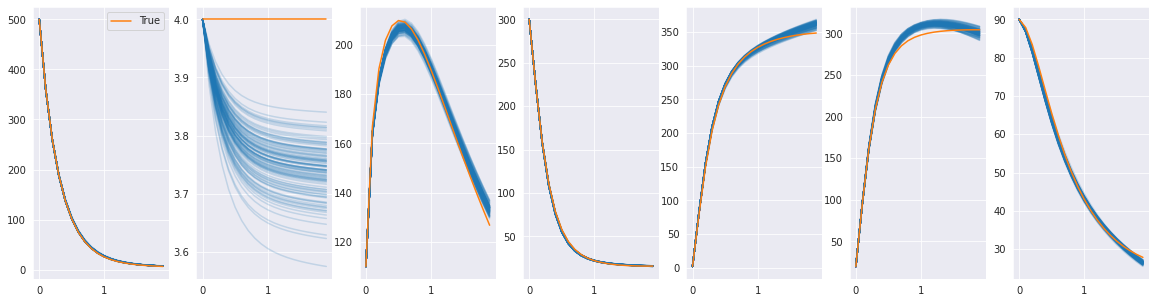

In [30]:
fig, ax = plt.subplots(1,7)
for i in range(100):
    inferred_rates = fit_horseshoe_ndx.stan_variables()['rates'][i,:]
    inferred_rates[inferred_rates < 1e-4] = 0
    def dZdt_inf(Z, t = 0):
        ap = np.hstack([Z, 1]) * (R_ndx == 1)
        ap += (np.hstack([Z, 1]) * (R_ndx == 2)) ** 2
        ap_mask = ap + (ap == 0).astype(np.float32)
        extend_Z = np.prod(ap_mask, axis = 1) * inferred_rates
        return (S_ndx.T @ extend_Z)[:-1]
    Z_obs_inf = integrate.odeint(dZdt_inf, [500, 4, 110, 300, 2, 20, 90], t)
    for i in range(7):
        ax[i].plot(t, Z_obs_inf[:, i], alpha = 0.2, color = 'C0')

for i in range(7):
    ax[i].plot(t, Z_obs[:, i], label = "True", color = 'C1')

ax[0].legend()
fig.set_size_inches(20, 5)

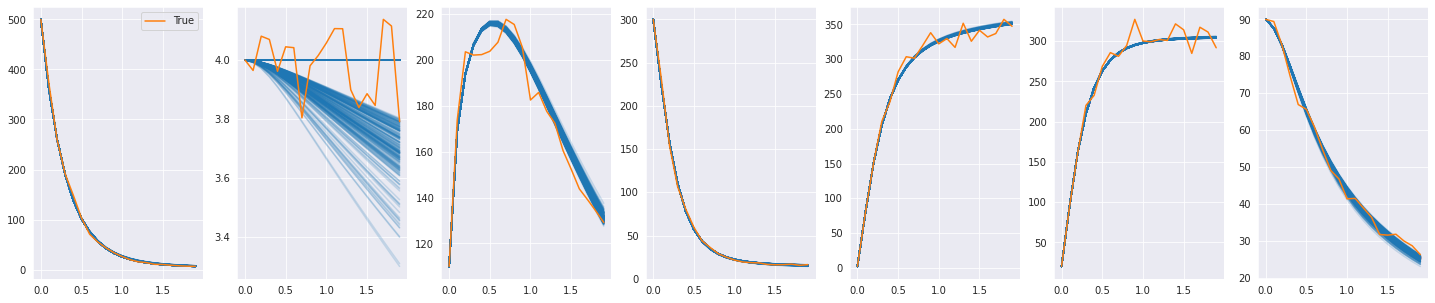

In [36]:
fig, ax = plt.subplots(1,7)
n_nonzero = []
for i in range(900, 1200):#fit_horseshoe_ndx.stan_variables()['rates'].shape[0]):
    inferred_rates = fit_horseshoe_ndx.stan_variables()['rates'][i,:]
    inferred_rates[inferred_rates < 1e-4] = 0
    n_nonzero.append(np.sum(inferred_rates != 0))
    #print(inferred_rates)
    def dZdt_inf(Z, t = 0):
        ap = np.hstack([Z, 1]) * (R_ndx == 1)
        ap += (np.hstack([Z, 1]) * (R_ndx == 2)) ** 2
        ap_mask = ap + (ap == 0).astype(np.float32)
        extend_Z = np.prod(ap_mask, axis = 1) * inferred_rates
        return (S_ndx.T @ extend_Z)[:-1]
    Z_obs_inf = integrate.odeint(dZdt_inf, [500, 4, 110, 300, 2, 20, 90], t)
    for i in range(7):
        ax[i].plot(t, Z_obs_inf[:, i], alpha = 0.2, color = 'C0')

for i in range(7):
    ax[i].plot(t, Z_obs_noisy[:, i], color = 'C1', label = "True")
    
ax[0].legend()
fig.set_size_inches(25, 5)

In [38]:
n_nonzero

[8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 8,
 8,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 7,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 8,
 9,
 9,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
